In [53]:
# IMPORTS
import numpy as np
import pandas as pd
import sklearn.mixture as mix
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn import hmm

In [6]:
# DATA RETREIVAL
start_date = "2017-01-1"
end_date = "2024-06-1"
symbol = "SPY"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Close", "Volume"]]
data.head(3)

[*********************100%%**********************]  1 of 1 completed


c:\Users\parke\miniconda3\envs\TradingModels\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,78379000


In [8]:
df = data.copy()
df["Log"] = np.log(df["Close"])
df["Returns"] = df["Log"].pct_change()
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Log,Returns,Range
Date,,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,226.580002,78744400,5.423098,0.001095,0.005053
2017-01-05,226.270004,226.580002,225.479996,226.399994,78379000,5.422303,-0.000147,0.004879
2017-01-06,226.529999,227.750000,225.899994,227.210007,71559900,5.425875,0.000659,0.008189


In [113]:
X_train = df[["Returns", "Range"]]
X_train.head(3)

,Returns,Range
Date,,
2017-01-04,0.001095,0.005053
2017-01-05,-0.000147,0.004879
2017-01-06,0.000659,0.008189


In [114]:
# GAUSSIAN MIXTURE MODEL
gmm_model = mix.GaussianMixture(n_components=4, covariance_type="full", n_init=100).fit(X_train)

In [21]:
# HIDDEN MARKOV MODEL
# hmm_model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=100).fit(X_train)

In [115]:
hidden_states = gmm_model.predict(X_train)

In [116]:
# Structure prices for chart plotting
prices = df["Close"].values.astype(float)
assert len(prices) == len(hidden_states), "Something's wrong"

labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []

i = 0
for state in hidden_states:
    if state == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if state == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if state == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if state == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

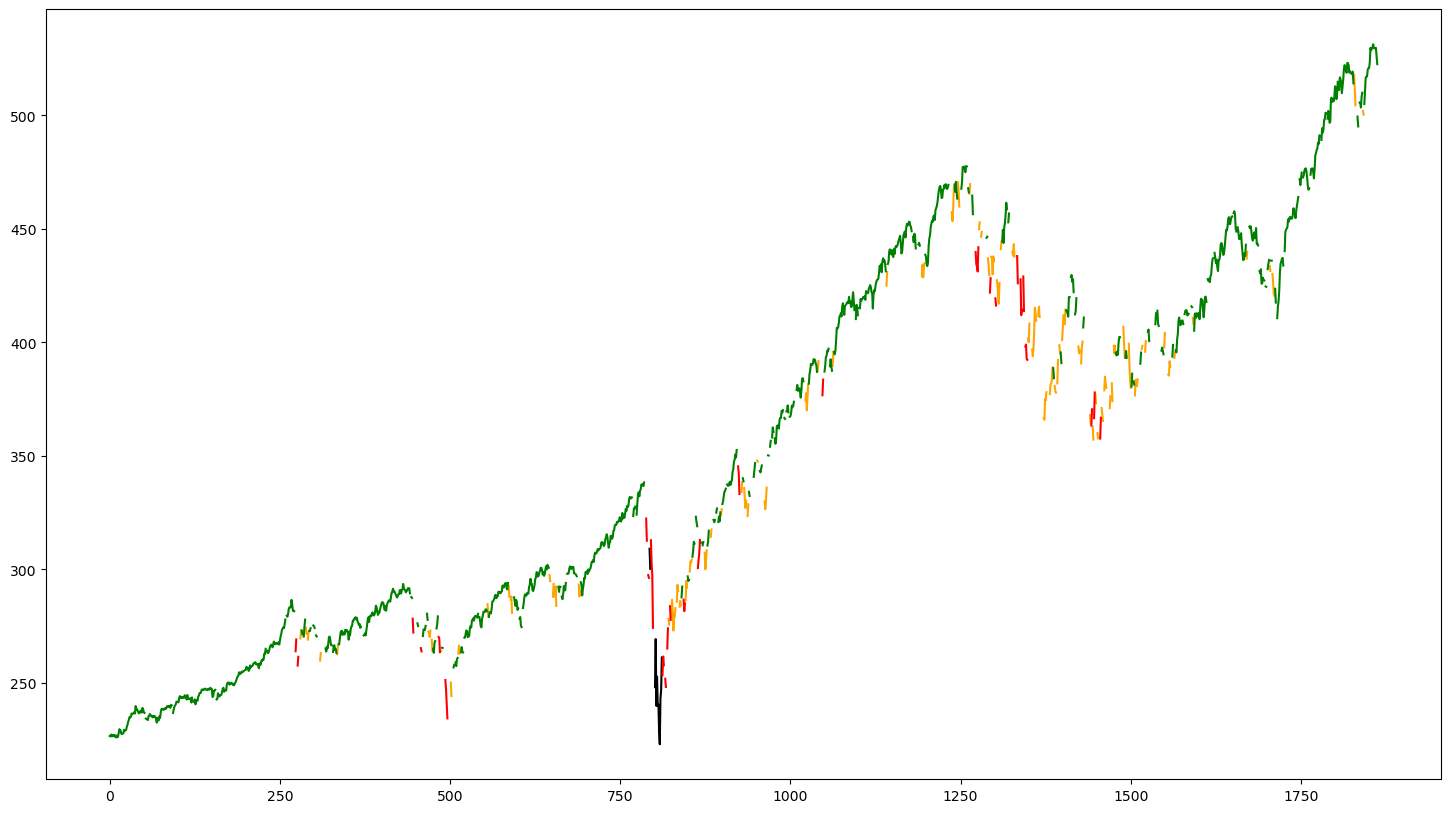

In [119]:
# Plot chart
fig = plt.figure(figsize=(18,10))
plt.plot(labels_0, color="orange")
plt.plot(labels_1, color="black")
plt.plot(labels_2, color="green")
plt.plot(labels_3, color="red")
plt.show()

In [124]:
from helpers import StrategyManager
strat_mgr = StrategyManager(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


c:\Users\parke\miniconda3\envs\TradingModels\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [125]:
# Extract the modified data
df_strat_mgr = strat_mgr.df

In [126]:
# Check MA Strategy performance
strat_df, sharpe_b, sharpe_s = strat_mgr.backtest_ma_crossover(12, 21, "long", drop_cols=["High", "Low", "Volume"])

Sense check:  1.315 1.315


Sharpe Ratio Base Strategy Benchmark:  0.583
Sharpe Ratio Base Strategy:  0.237


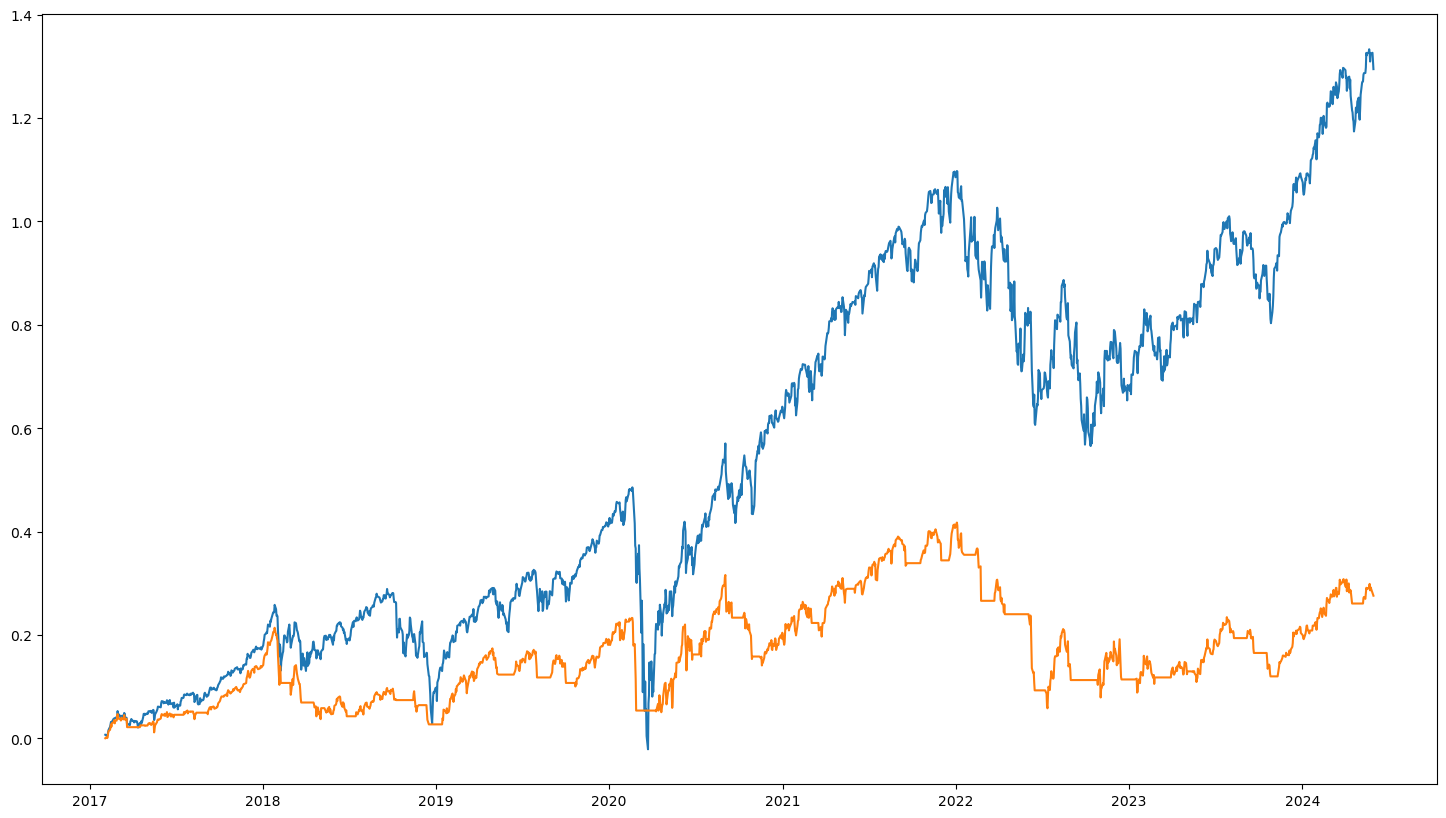

In [127]:
# Review equity curve and metrics
print("Sharpe Ratio Base Strategy Benchmark: ", sharpe_b)
print("Sharpe Ratio Base Strategy: ", sharpe_s)

fig = plt.figure(figsize = (18,10))
plt.plot(strat_df["Bench_C_Rets"])
plt.plot(strat_df["Strat_C_Rets"])
plt.show()

In [128]:
# Set Favourable States - !!!!!!!!! ADJUST BASED ON HMM RESULTS AND TEST OUTCOME !!!!!!!!!!!!!!!!!!!!
favourable_states = [0,2]

# Write Strategy
state_signals = []
for state in hidden_states:
    if state in favourable_states:
        state_signals.append(1)
    else:
        state_signals.append(0)
print("Lengh of States: ", len(state_signals))

Lengh of States:  1864


In [129]:
# Replace Strategy Dataframe
df_strat_mgr_test = df.copy()
df_strat_mgr_test = df_strat_mgr_test.tail(len(X_train))
df_strat_mgr_test["PSignal"] = state_signals
strat_mgr.change_df(df_strat_mgr_test)
strat_mgr.df.head()

,Open,High,Low,Close,Volume,Log,Returns,Range,PSignal
Date,,,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,226.580002,78744400,5.423098,0.001095,0.005053,1
2017-01-05,226.270004,226.580002,225.479996,226.399994,78379000,5.422303,-0.000147,0.004879,1
2017-01-06,226.529999,227.750000,225.899994,227.210007,71559900,5.425875,0.000659,0.008189,1
2017-01-09,226.910004,227.070007,226.419998,226.460007,46939700,5.422568,-0.000609,0.002871,1
2017-01-10,226.479996,227.449997,226.009995,226.460007,63771900,5.422568,0.000000,0.006371,1


In [130]:
strat_df_2, sharpe_b_2, sharpe_s_2 = strat_mgr.backtest_ma_crossover(12, 21, "long")

Sense check:  1.315 1.315


Sharpe Ratio Benchmark:  0.583
Sharpe Ratio Regime Strategy with MA Cross:  0.214
Returns Benchmark: 129.45%
Returns Regime Strategy with MA Cross: 23.36%


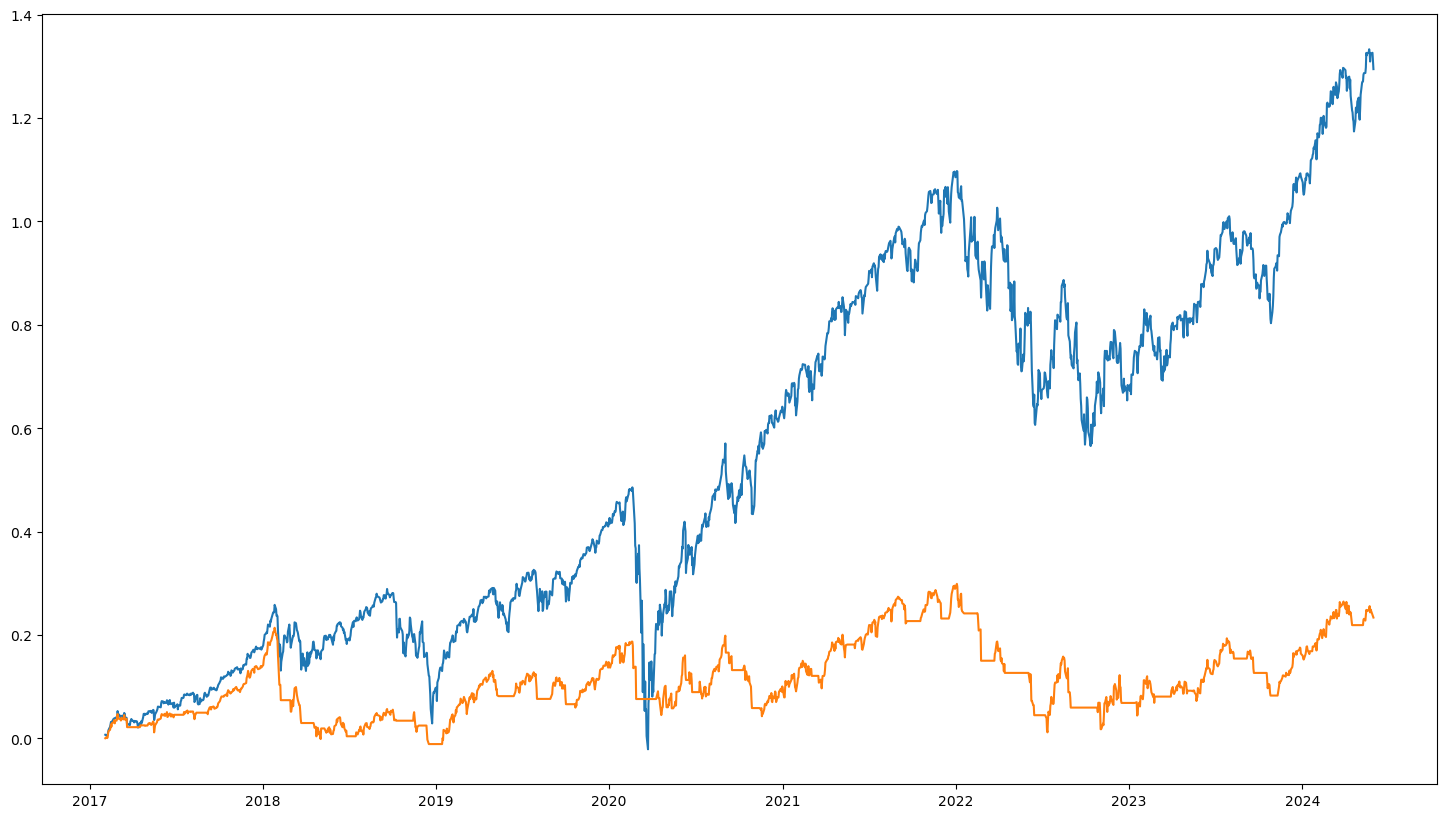

In [131]:
# Review equity curve
print("Sharpe Ratio Benchmark: ", sharpe_b_2)
print("Sharpe Ratio Regime Strategy with MA Cross: ", sharpe_s_2)
print(f"Returns Benchmark: {round(strat_df_2['Bench_C_Rets'].values[-1] * 100, 2)}%")
print(f"Returns Regime Strategy with MA Cross: {round(strat_df_2['Strat_C_Rets'].values[-1] * 100, 2)}%")

fig = plt.figure(figsize = (18, 10))
plt.plot(strat_df_2["Bench_C_Rets"])
plt.plot(strat_df_2["Strat_C_Rets"])
plt.show()